In [ ]:
!pip install opencv-python

In [ ]:
!pip install scikit-image

In [1]:
### all packages needed

import cv2
import numpy as np
from skimage import morphology
from pyefd import elliptic_fourier_descriptors
import mahotas
import matplotlib.pyplot as plt

In [ ]:
### STEP 1: invariance normalization
# Shuo Li & Ji Li

In [2]:
# Image size and (future) orientation policy
TARGET_SIZE = (90, 90)
# Note:
# Orientation policy is defined for later pipeline stages.
# Step 1 does not perform rotation
ELONGATED_FRUITS = {"cucumber", "carrot"}  # may apply rotation in later stages
SPHERICAL_FRUITS = {"apple", "orange"}     # no rotation needed


# -------- Step 1: Input & Basic Normalisation --------
def load_and_normalize(path, target_size=TARGET_SIZE):
    # Read image from file
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f"Could not read image: {path}")

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Resize to a fixed resolution
    img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)

    # --- (A) Light Gaussian smoothing to suppress sensor noise
    # (small kernel to preserve edges for segmentation stage) ---
    img_resized = cv2.GaussianBlur(img_resized, (3, 3), 0)

    # --- (B) Gray-world white balance (color constancy) ---
    img_float = img_resized.astype(np.float32)
    mean_rgb = img_float.reshape(-1, 3).mean(axis=0)
    mean_gray = mean_rgb.mean()
    scale = mean_gray / (mean_rgb + 1e-6)
    img_wb = img_float * scale
    img_wb = np.clip(img_wb, 0, 255).astype(np.uint8)

    # --- (C) Illumination normalization: CLAHE on V channel ---
    hsv = cv2.cvtColor(img_wb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v2 = clahe.apply(v)
    hsv2 = cv2.merge((h, s, v2))
    img_norm = cv2.cvtColor(hsv2, cv2.COLOR_HSV2RGB)

    # Ensure output is uint8
    img_norm = img_norm.astype(np.uint8)

    return img_norm

In [9]:
import os
print(os.path.exists("/home/zilou/Liveproject/01610963_001.jpg"))


True


Shape: (90, 90, 3) Dtype: uint8


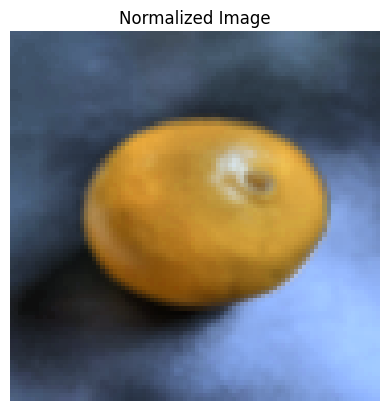

In [29]:
path = "/home/zilou/Liveproject/01610963_001.jpg"

img = load_and_normalize(path)  # 原图归一化
print("Shape:", img.shape, "Dtype:", img.dtype)
plt.imshow(img)
plt.title("Normalized Image")
plt.axis("off")
plt.show()


In [ ]:
### STEP 2-1: segmentation
# Changrong Zheng

In [25]:
# Design goals (per proposal):
# - Colour-based segmentation (preferred over grayscale for similarly-shaped items with different chromatic patterns)
# - Produce a binary mask (0 = background, 255 = object) for downstream shape + colour feature extraction
# - Keep this step *structural-free*: mask refinement is handled in STEP 3
from skimage.filters import threshold_otsu

def _corner_samples(arr: np.ndarray, patch: int = 10) -> np.ndarray:
    """Collect pixels from four corner patches (shape: [N, C])."""
    H, W = arr.shape[:2]
    p = int(min(patch, H // 2, W // 2))
    if p <= 0:
        return arr.reshape(-1, arr.shape[-1])
    corners = np.concatenate(
        [
            arr[:p, :p].reshape(-1, arr.shape[-1]),
            arr[:p, -p:].reshape(-1, arr.shape[-1]),
            arr[-p:, :p].reshape(-1, arr.shape[-1]),
            arr[-p:, -p:].reshape(-1, arr.shape[-1]),
        ],
        axis=0,
    )
    return corners

def segment_fruit(
    img_rgb: np.ndarray,
    patch: int = 10,
    bg_quantile: float = 0.995,
    v_min_floor: int = 20,
    reg: float = 1e-3,
) -> np.ndarray:
    """Colour-based segmentation using a background chroma model.

    This function uses Step 1's normalised RGB image (uint8) and returns a *raw*
    binary mask. Any morphological/structural cleanup (hole-filling, largest CC,
    closing/opening, etc.) is intentionally deferred to STEP 3.

    Method summary
    -------------
    1) Convert RGB -> Lab and HSV.
    2) Estimate a background model from corner patches using Lab chroma (a*, b*).
       Background pixels should be close to the corners in typical acquisitions.
    3) Compute per-pixel (regularised) Mahalanobis distance in (a*, b*) space.
    4) Threshold distances to obtain a binary mask; auto-correct if too strict/loose.

    Parameters
    ----------
    img_rgb : np.ndarray
        Normalised RGB image (H x W x 3), uint8, typically 90x90.
    patch : int
        Corner patch size used to estimate background statistics.
    bg_quantile : float
        Quantile of background distance used as the initial threshold.
    v_min_floor : int
        Minimum V (brightness) floor to suppress very dark noise.
    reg : float
        Diagonal regularisation added to the background covariance (stability).

    Returns
    -------
    mask : np.ndarray
        uint8 mask with values {0, 255}, same height/width as the input.
    """
    if img_rgb.dtype != np.uint8:
        # Be defensive: Step 1 returns uint8, but keep this robust.
        img_rgb = np.clip(img_rgb, 0, 255).astype(np.uint8)

    H, W = img_rgb.shape[:2]

    # Colour spaces
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

    # Background samples from corners
    bg_hsv = _corner_samples(hsv, patch=patch).astype(np.float32)
    bg_lab = _corner_samples(lab, patch=patch).astype(np.float32)

    # Use chroma only (a*, b*) for colour separation
    bg_ab = bg_lab[:, 1:3]
    mu = bg_ab.mean(axis=0)

    # Regularised covariance for stability on small samples
    cov = np.cov(bg_ab.T)
    if cov.shape != (2, 2):  # safety for degenerate cases
        cov = np.eye(2, dtype=np.float32)
    cov = cov.astype(np.float32) + float(reg) * np.eye(2, dtype=np.float32)

    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov)

    # Mahalanobis distance map in ab-space
    ab = lab[..., 1:3].reshape(-1, 2).astype(np.float32)
    diff = ab - mu.reshape(1, 2)
    d2 = np.einsum("ij,jk,ik->i", diff, inv_cov, diff).reshape(H, W)

    # Brightness guardrail using V
    bg_v_mean = float(bg_hsv[:, 2].mean())
    bg_v_std = float(bg_hsv[:, 2].std())
    v_min = int(max(v_min_floor, bg_v_mean - 2.0 * bg_v_std))
    V = hsv[..., 2].astype(np.int32)

    # Threshold from background distance distribution
    # (use corner distances as a proxy for the background class)
    bg_d2 = d2.copy()
    # Only take distances in corner patches (same sampling geometry)
    bg_d2_samp = _corner_samples(bg_d2[..., None], patch=patch).reshape(-1)
    tau = float(np.quantile(bg_d2_samp, bg_quantile))

    raw = ((d2 > tau) & (V >= v_min)).astype(np.uint8) * 255

    # Auto-correct if threshold is too strict/too loose
    frac = raw.mean() / 255.0
    if frac < 0.03 or frac > 0.90:
        # Fallback 1: Otsu on distance map (often works when background stats are messy)
        try:
            tau2 = float(threshold_otsu(d2.astype(np.float32)))
            raw2 = ((d2 > tau2) & (V >= v_min)).astype(np.uint8) * 255
            frac2 = raw2.mean() / 255.0
            if 0.03 <= frac2 <= 0.90:
                raw = raw2
                frac = frac2
        except Exception:
            pass

    if frac < 0.03:
        # Fallback 2: saturation thresholding (simple but robust on light backgrounds)
        S = hsv[..., 1].astype(np.int32)
        bg_s_mean = float(bg_hsv[:, 1].mean())
        bg_s_std = float(bg_hsv[:, 1].std())
        s_thresh = int(np.clip(bg_s_mean + 2.5 * bg_s_std, 25, 240))
        raw = ((S >= s_thresh) & (V >= v_min)).astype(np.uint8) * 255

    return raw

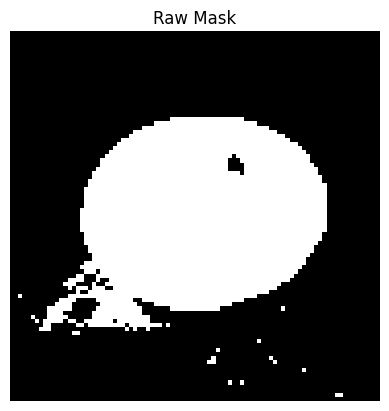

Unique values in raw mask: [  0 255]


In [30]:
mask_raw = segment_fruit(img)  # 原始 mask
plt.imshow(mask_raw, cmap="gray")
plt.title("Raw Mask")
plt.axis("off")
plt.show()
print("Unique values in raw mask:", np.unique(mask_raw))



In [ ]:
### STEP 2-2: segmentation
# Bowen Su

In [26]:
from scipy.signal import wiener

def _to_float01(img_bgr: np.ndarray) -> np.ndarray:
    img = img_bgr.astype(np.float32)
    if img.max() > 1.5:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def _to_uint8(img01: np.ndarray) -> np.ndarray:
    return np.clip(img01 * 255.0 + 0.5, 0, 255).astype(np.uint8)

def _apply_mask_preserve_bg(img01: np.ndarray, mask01: np.ndarray, filtered01: np.ndarray) -> np.ndarray:
    """
    Keep background as original; replace only inside mask.
    mask01 is 0/1 float or uint8 (0/255).
    """
    m = mask01.astype(np.float32)
    if m.max() > 1.5:
        m = (m / 255.0)
    m = (m > 0.5).astype(np.float32)
    if img01.ndim == 3:
        m = m[..., None]
    return filtered01 * m + img01 * (1.0 - m)

# SIGF: Structural Interval Gradient Filtering

def sigf_filter(
    img_bgr: np.ndarray,
    mask: np.ndarray | None = None,
    offsets=(1, 2, 4),
    alpha=0.6,
    base_blur_ksize=5,
) -> np.ndarray:
    """
    Practical SIGF-style filter:
    - Compute multi-interval gradients (differences across offsets) to emphasize structural edges.
    - Use them to drive an edge-preserving sharpening inside the object region.

    Parameters
    ----------
    offsets : tuple of ints
        Interval sizes (pixels) used to compute "interval gradients".
    alpha : float
        Strength of structure enhancement.
    base_blur_ksize : int
        Base blur kernel for the "detail" term. Must be odd.

    Returns
    -------
    uint8 BGR image
    """
    img01 = _to_float01(img_bgr)
    gray = cv2.cvtColor(_to_uint8(img01), cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    # Multi-interval gradient magnitude (structure map)
    g_acc = np.zeros_like(gray, dtype=np.float32)
    for d in offsets:
        # interval difference in x and y directions
        gx = np.zeros_like(gray)
        gy = np.zeros_like(gray)
        gx[:, d:] = gray[:, d:] - gray[:, :-d]
        gy[d:, :] = gray[d:, :] - gray[:-d, :]
        g = np.sqrt(gx * gx + gy * gy)
        g_acc += g

    # Normalize structure strength to [0,1]
    g_acc -= g_acc.min()
    denom = (g_acc.max() - g_acc.min() + 1e-8)
    s = np.clip(g_acc / denom, 0.0, 1.0)  # structure weight

    # "Detail" term (unsharp mask), then gate by structure map
    k = base_blur_ksize if base_blur_ksize % 2 == 1 else base_blur_ksize + 1
    blurred = cv2.GaussianBlur(img01, (k, k), 0)
    detail = img01 - blurred

    # Gate enhancement by structure map: more enhancement near edges/structures
    s3 = s[..., None]
    enhanced = np.clip(img01 + alpha * s3 * detail, 0.0, 1.0)

    if mask is not None:
        enhanced = _apply_mask_preserve_bg(img01, mask, enhanced)

    return _to_uint8(enhanced)


# CWF: Color Wiener Filtering (with RGB correlation)

def color_wiener_filter(
    img_bgr: np.ndarray,
    mask: np.ndarray | None = None,
    win_size=5,
    noise_sigma: float | None = None,
) -> np.ndarray:
    """
    A practical "color Wiener" approach that respects RGB correlation:
    1) Decorrelate color channels via PCA (computed from pixels, optionally within mask).
    2) Apply classic Wiener filter on each decorrelated component.
    3) Transform back to BGR.

    This is a strong baseline for "color Wiener while respecting RGB correlations".

    Parameters
    ----------
    win_size : int
        Wiener window size for scipy.signal.wiener (odd recommended).
    noise_sigma : float or None
        If provided, used as noise estimate in Wiener (as noise variance = sigma^2).
        If None, Wiener uses its internal local variance estimate.

    Returns
    -------
    uint8 BGR image
    """
    img01 = _to_float01(img_bgr)
    h, w, _ = img01.shape

    # Flatten pixels for PCA fit
    X = img01.reshape(-1, 3).astype(np.float32)

    if mask is not None:
        m = mask.astype(np.float32)
        if m.max() > 1.5:
            m = m / 255.0
        m = (m.reshape(-1) > 0.5)
        X_fit = X[m] if np.any(m) else X
    else:
        X_fit = X

    # PCA (covariance eigendecomposition)
    mu = X_fit.mean(axis=0, keepdims=True)
    Xc = X_fit - mu
    C = (Xc.T @ Xc) / max(Xc.shape[0] - 1, 1)
    evals, evecs = np.linalg.eigh(C)
    # sort descending
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]

    # Transform all pixels to PCA space
    X_all_c = X - mu
    Z = X_all_c @ evecs  # (N,3)
    Z_img = Z.reshape(h, w, 3)

    # Wiener filter each PCA component (now ~decorrelated)
    Zf = np.empty_like(Z_img, dtype=np.float32)
    noise = None if noise_sigma is None else float(noise_sigma**2)
    for c in range(3):
        Zf[:, :, c] = wiener(Z_img[:, :, c], mysize=win_size, noise=noise).astype(np.float32)

    # Back to RGB/BGR
    Zf_flat = Zf.reshape(-1, 3)
    Xf = (Zf_flat @ evecs.T) + mu  # inverse PCA
    out01 = np.clip(Xf.reshape(h, w, 3), 0.0, 1.0)

    if mask is not None:
        out01 = _apply_mask_preserve_bg(img01, mask, out01)

    return _to_uint8(out01)

# GBF: Guided Box Filtering

def guided_box_filter(
    src_bgr: np.ndarray,
    guide_bgr: np.ndarray | None = None,
    mask: np.ndarray | None = None,
    radius=8,
    eps=1e-3,
) -> np.ndarray:
    """
    Guided filter using box filters (a.k.a. guided box filtering).
    - If guide_bgr is None, self-guided filtering is used.

    Implementation: guided filter for grayscale guidance to keep it simple & stable.
    (In fruit images, grayscale guidance preserves boundaries well.)

    Parameters
    ----------
    radius : int
        Window radius r; window size is (2r+1).
    eps : float
        Regularization; larger -> more smoothing.

    Returns
    -------
    uint8 BGR image
    """
    src01 = _to_float01(src_bgr)
    guide01 = src01 if guide_bgr is None else _to_float01(guide_bgr)

    # Use grayscale guidance
    I = cv2.cvtColor(_to_uint8(guide01), cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    r = int(radius)
    ksize = (2 * r + 1, 2 * r + 1)

    # Precompute mean_I, var_I via box filter
    mean_I = cv2.boxFilter(I, ddepth=-1, ksize=ksize, normalize=True)
    mean_II = cv2.boxFilter(I * I, ddepth=-1, ksize=ksize, normalize=True)
    var_I = mean_II - mean_I * mean_I

    out = np.empty_like(src01, dtype=np.float32)

    # Apply guided filter per channel of src
    for ch in range(3):
        P = src01[:, :, ch]
        mean_P = cv2.boxFilter(P, ddepth=-1, ksize=ksize, normalize=True)
        mean_IP = cv2.boxFilter(I * P, ddepth=-1, ksize=ksize, normalize=True)
        cov_IP = mean_IP - mean_I * mean_P

        a = cov_IP / (var_I + eps)
        b = mean_P - a * mean_I

        mean_a = cv2.boxFilter(a, ddepth=-1, ksize=ksize, normalize=True)
        mean_b = cv2.boxFilter(b, ddepth=-1, ksize=ksize, normalize=True)

        Q = mean_a * I + mean_b
        out[:, :, ch] = Q

    out01 = np.clip(out, 0.0, 1.0)

    if mask is not None:
        out01 = _apply_mask_preserve_bg(src01, mask, out01)

    return _to_uint8(out01)

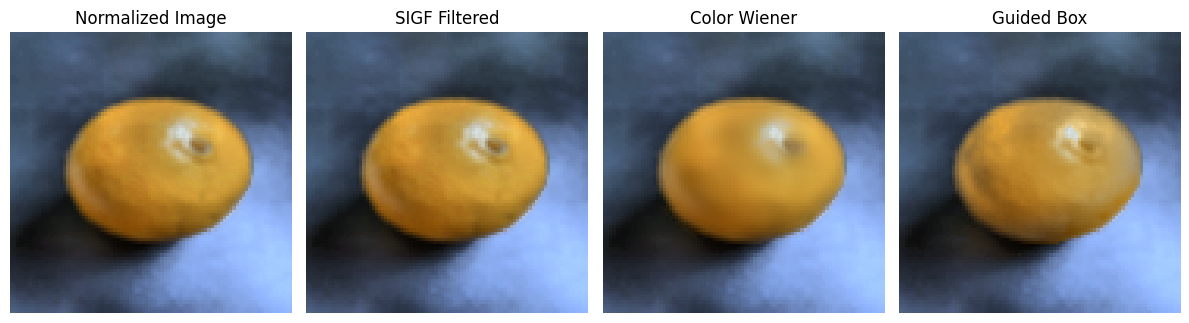

In [31]:
img_sigf = sigf_filter(img, mask=mask_raw)
img_cwf = color_wiener_filter(img, mask=mask_raw)  
img_gbf = guided_box_filter(img, mask=mask_raw)


plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Normalized Image")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(img_sigf)
plt.title("SIGF Filtered")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(img_cwf)
plt.title("Color Wiener")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(img_gbf)
plt.title("Guided Box")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
### STEP 3: mask refinement
# Jinnan Li

In [14]:
import numpy as np
from skimage import morphology, measure


# 1. Mask Refinement Function
def refine_mask(
    mask: np.ndarray,
    hole_area: int = 200,
    min_object_size: int = 300,
    closing_radius: int = 5,
    opening_radius: int = 2,
) -> np.ndarray:
    """
    Structural mask refinement with tunable parameters.

    Args:
        mask: Input binary mask (any numeric dtype; nonzero = foreground).
        hole_area: Max area of internal holes to fill (pixels).
        min_object_size: Minimum connected component size to keep (pixels).
        closing_radius: Disk radius for morphological closing.
        opening_radius: Disk radius for morphological opening.

    Returns:
        Refined binary mask as uint8 with values {0, 255}.
    """

    # Convert to boolean
    mask_bool = mask > 0

    # Fill small internal holes
    mask_filled = morphology.remove_small_holes(
        mask_bool,
        area_threshold=hole_area
    )

    # Remove small objects (noise)
    mask_clean = morphology.remove_small_objects(
        mask_filled,
        min_size=min_object_size
    )

    # Morphological closing (bridge gaps)
    if closing_radius > 0:
        mask_clean = morphology.closing(
            mask_clean,
            morphology.disk(closing_radius)
        )

    # Morphological opening (remove thin artifacts)
    if opening_radius > 0:
        mask_clean = morphology.opening(
            mask_clean,
            morphology.disk(opening_radius)
        )

    # Keep largest connected component
    labeled = measure.label(mask_clean)
    if labeled.max() == 0:
        # Fallback to hole-filled version
        return mask_filled.astype(np.uint8) * 255

    regions = measure.regionprops(labeled)
    largest = max(regions, key=lambda r: r.area)

    mask_final = labeled == largest.label
    return mask_final.astype(np.uint8) * 255


# 2. Structural Quality Score
def mask_quality_score(mask: np.ndarray) -> float:
    """
    Structural quality score.
    Lower score = better mask.

    Combines:
        - Solidity
        - Boundary smoothness
        - Coverage
    """

    binary = mask > 0
    labeled = measure.label(binary)
    props = measure.regionprops(labeled)

    if not props:
        return np.inf

    region = max(props, key=lambda r: r.area)
    area = region.area
    convex_area = region.area_convex
    perimeter = region.perimeter

    if area == 0 or convex_area == 0:
        return np.inf

    # Solidity
    solidity = area / convex_area
    solidity_penalty = 1.0 - solidity

    # Boundary smoothness
    # Compactness-like metric
    roughness = (perimeter ** 2) / (4 * np.pi * area)

    roughness_penalty = max(0.0, roughness - 1.2)

    # Coverage
    image_area = binary.size
    coverage = area / image_area
    coverage_penalty = max(0.0, 0.02 - coverage)  # penalize extremely tiny masks

    # Weighted score
    score = (
        0.6 * solidity_penalty +
        0.3 * roughness_penalty +
        0.1 * coverage_penalty
    )

    return float(score)


# 3. Automatic Parameter Optimization
def optimize_mask(raw_mask: np.ndarray):
    """
    Grid-search refinement parameters.

    Returns:
        best_mask
        best_params
        best_score
    """

    best_score = np.inf
    best_mask = None
    best_params = None

    param_grid = dict(
        hole_area=[100, 200, 400],
        min_object_size=[200, 300, 500],
        closing_radius=[3, 5, 7],
        opening_radius=[1, 2],
    )

    for hole_area in param_grid["hole_area"]:
        for min_size in param_grid["min_object_size"]:
            for closing_radius in param_grid["closing_radius"]:
                for opening_radius in param_grid["opening_radius"]:

                    if opening_radius >= closing_radius:
                        continue

                    refined = refine_mask(
                        raw_mask,
                        hole_area=hole_area,
                        min_object_size=min_size,
                        closing_radius=closing_radius,
                        opening_radius=opening_radius,
                    )

                    score = mask_quality_score(refined)

                    if score < best_score:
                        best_score = score
                        best_mask = refined
                        best_params = {
                            "hole_area": hole_area,
                            "min_object_size": min_size,
                            "closing_radius": closing_radius,
                            "opening_radius": opening_radius,
                        }

    # Fallback safety
    if best_mask is None:
        best_mask = refine_mask(raw_mask)
        best_params = {}
        best_score = mask_quality_score(best_mask)

    return best_mask, best_params, best_score

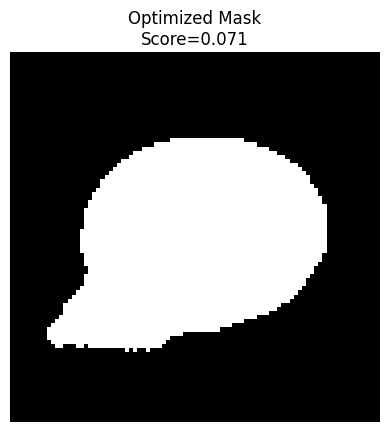

Best params: {'hole_area': 100, 'min_object_size': 200, 'closing_radius': 7, 'opening_radius': 2}


In [32]:
best_mask, best_params, best_score = optimize_mask(mask_raw)  # 保留原优化逻辑
plt.imshow(best_mask, cmap="gray")
plt.title(f"Optimized Mask\nScore={best_score:.3f}")
plt.axis("off")
plt.show()
print("Best params:", best_params)


In [ ]:
### STEP 4: shape representation
# Yu-Chao Huang & Yudi Wang

In [34]:
def compute_shape_features(mask_clean):
    """
    Extract advanced shape features from refined mask.
    """
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_NONE)
    
    if len(contours) == 0:
        raise ValueError("No contour found in mask.")

    cnt = max(contours, key=cv2.contourArea)

    # -------------------------
    # Boundary smoothing
    # -------------------------
    pts = cnt[:, 0, :].astype(np.float32)

    # Gaussian smoothing along contour
    ksize = 5
    pts_smooth = np.copy(pts)
    pts_smooth[:, 0] = cv2.GaussianBlur(pts[:, 0], (ksize, 1), 0).flatten()
    pts_smooth[:, 1] = cv2.GaussianBlur(pts[:, 1], (ksize, 1), 0).flatten()

    cnt_smooth = pts_smooth.reshape(-1, 1, 2).astype(np.int32)

    # -------------------------
    # Geometric features
    # -------------------------
    area = cv2.contourArea(cnt_smooth)
    perimeter = cv2.arcLength(cnt_smooth, True)
    perimeter_norm = perimeter / (np.sqrt(area) + 1e-6)
    circularity = (4 * np.pi * area) / (perimeter * perimeter + 1e-6)

    # -------------------------
    # Solidity
    # -------------------------
    hull = cv2.convexHull(cnt_smooth)
    hull_area = cv2.contourArea(hull)
    solidity = area / (hull_area + 1e-6)

    # -------------------------
    # Eccentricity
    # -------------------------
    if len(cnt_smooth) >= 5:
        ellipse = cv2.fitEllipse(cnt_smooth)
        (_, axes, _) = ellipse
        major_axis = max(axes)
        minor_axis = min(axes)
        eccentricity = np.sqrt(1 - (minor_axis / (major_axis + 1e-6))**2)
    else:
        eccentricity = 0.0

    # -------------------------
    # Curvature (smoothed)
    # -------------------------
    dx = np.gradient(pts_smooth[:, 0])
    dy = np.gradient(pts_smooth[:, 1])
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    curvature = np.mean(
        np.abs(dx * ddy - dy * ddx) /
        (dx * dx + dy * dy + 1e-6) ** 1.5
    )

    # -------------------------
    # Elliptic Fourier Descriptors
    # -------------------------
    efd = elliptic_fourier_descriptors(pts_smooth, order=10, normalize=True)
    efd_flat = efd.flatten()

    # -------------------------
    # Radial Distance Signature
    # -------------------------
    moments = cv2.moments(cnt_smooth)
    cx = moments["m10"] / (moments["m00"] + 1e-6)
    cy = moments["m01"] / (moments["m00"] + 1e-6)

    radial = np.sqrt((pts_smooth[:, 0] - cx)**2 +
                     (pts_smooth[:, 1] - cy)**2)

    radial_norm = radial / (np.mean(radial) + 1e-6)

    # FFT of radial signature (keep low freq)
    radial_fft = np.abs(np.fft.fft(radial_norm))
    radial_descriptor = radial_fft[:15]  # low-frequency components

    # -------------------------
    # Zernike Moments
    # -------------------------
    radius = min(mask_clean.shape) // 2
    zernike = mahotas.features.zernike_moments(mask_clean, radius, degree=8)

    # -------------------------
    # Return upgraded feature set
    # -------------------------
    shape_features = {
        "area": area,
        "perimeter": perimeter,
        "perimeter_norm": perimeter_norm,
        "circularity": circularity,
        "solidity": solidity,
        "eccentricity": eccentricity,
        "curvature": curvature,
        "efd": efd_flat,
        "radial_signature": radial_descriptor,
        "zernike": zernike,
    }

    return shape_features




In [35]:
shape_feats = compute_shape_features(best_mask)

In [ ]:
### STEP 5: ripeness
# Trevor DeButch & Rohit Dalal

In [18]:
def circular_mean_std(h):
    """
    This helps convert the Hue measurements to radians due to the scale of 0-180 having 0 and 180 both be red,
    this way an apple with values of 2 and 179 wont average to 90(green hue) and will instead average to a red hue in radians
    """
    #convert to radians
    theta = (h.astype(np.float32) / 180.0) * 2.0 * np.pi

    #convert theta angles to unit circle locations
    sin_vals = np.sin(theta)
    cos_vals = np.cos(theta)

    sin_m = np.mean(sin_vals)
    cos_m = np.mean(cos_vals)

    #give averaged angle vector
    mean_theta = np.arctan2(sin_m, cos_m)

    #catch negatives
    if mean_theta < 0:
        mean_theta += 2.0 * np.pi

    #test closeness of values
    R = np.sqrt(sin_m**2 + cos_m**2)
    R = np.clip(R, 1e-6, 1.0)

    #get std
    circ_std = np.sqrt(-2.0 * np.log(R))

    #convert back to hue scale for final results
    # for feature space, sin/cos are better than mean_h because they preserve wrap-around (red near 0 and 180)
    std_h  = (circ_std / (2.0 * np.pi)) * 180.0

    return sin_m, cos_m, std_h


def compute_colour_features(img_rgb, mask_clean):
    """
    Ripeness features using circular Hue stats:
    [H_sin_mean, H_cos_mean, S_mean, V_mean, H_circ_std, S_std, V_std]
    """
    #get mask
    mask_bool = mask_clean.astype(bool)

    #grab h(hue) s(saturation) v(value) values to better deal with brighness of colors.
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    fruit_pixels = hsv[mask_bool]

    if fruit_pixels.size == 0:
        raise ValueError("No fruit pixels found for HSV colour features.")

    H = fruit_pixels[:, 0]
    S = fruit_pixels[:, 1].astype(np.float32)
    V = fruit_pixels[:, 2].astype(np.float32)

    # Hue is circular, so keep it on the unit circle (sin/cos) instead of raw mean hue
    h_sin_mean, h_cos_mean, h_std = circular_mean_std(H)

    s_mean, v_mean = float(S.mean()), float(V.mean())
    s_std,  v_std  = float(S.std()),  float(V.std())

    return np.array([h_sin_mean, h_cos_mean, s_mean, v_mean, h_std, s_std, v_std], dtype=np.float32)



In [37]:
colour_feats = compute_colour_features(img_cwf, best_mask)
print("Colour features:", colour_feats)


Colour features: [  0.5737635    0.74629134 161.78076    157.10051      9.959544
  58.81135     57.908337  ]


In [ ]:
### STEP 6 : feature extraction
# Tyler Schmidt & Camden Foster

In [21]:
def build_feature_vector(shape_features, colour_features):
    """
    Combine shape and colour features into a single classification-ready vector.
    """
    
    # Scalars only
    geom = np.array([
        shape_features["area"],
        shape_features["perimeter"],
        shape_features["perimeter_norm"],
        shape_features["circularity"],
        shape_features["solidity"],
        shape_features["eccentricity"],
        shape_features["curvature"]
    ], dtype=np.float32)

    # Vector features
    efd = np.array(shape_features["efd"], dtype=np.float32).flatten()
    radial = np.array(shape_features["radial_signature"], dtype=np.float32).flatten()
    zernike = np.array(shape_features["zernike"], dtype=np.float32).flatten()

    colour = np.array(colour_features, dtype=np.float32).flatten()

    # Combine everything
    feature_vector = np.hstack([
        geom,
        efd,
        radial,
        zernike,
        colour
    ])

    return feature_vector




def visualize_mask(img_rgb, mask, mask_refined=None):
    
    ncols = 3 if mask_refined is None else 4
    
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, ncols, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")
    
    # Raw mask
    plt.subplot(1, ncols, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Raw Mask")
    plt.axis("off")
    
    # Refined mask (if available)
    if mask_refined is not None:
        plt.subplot(1, ncols, 3)
        plt.imshow(mask_refined, cmap="gray")
        plt.title("Refined Mask")
        plt.axis("off")
        
        # Overlay
        overlay = img_rgb.copy()
        overlay[mask_refined == 0] = overlay[mask_refined == 0] * 0.3
        
        plt.subplot(1, ncols, 4)
        plt.imshow(overlay)
        plt.title("Mask Overlay")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


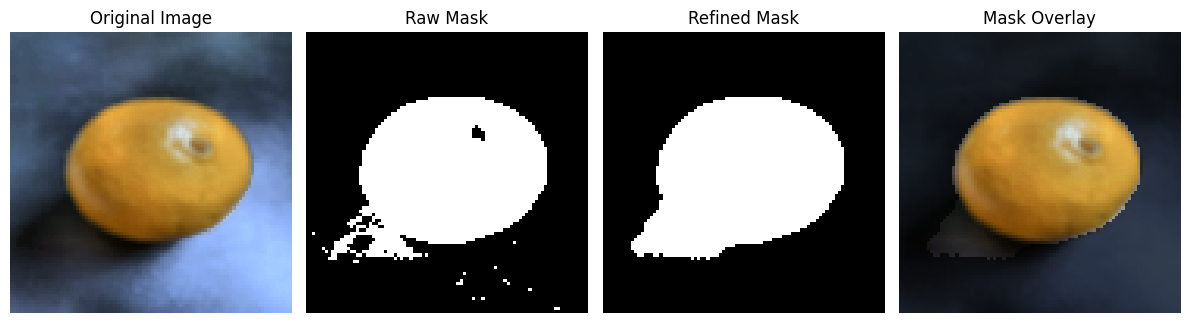

Feature vector type: <class 'numpy.ndarray'>
Feature vector dtype: float32
Feature vector shape: (94,)
Feature vector length: 94
Contains NaN: False
First 10 values: [ 2.4270000e+03  2.0582338e+02  4.1779170e+00  7.1992999e-01
  9.4638330e-01  7.3943061e-01  1.1917627e-01 -1.0000000e+00
  1.3696363e-16 -2.5140991e-16]


In [39]:
feature_vector = build_feature_vector(shape_feats, colour_feats)


visualize_mask(img, mask_raw, best_mask)


print("Feature vector type:", type(feature_vector))
print("Feature vector dtype:", feature_vector.dtype)
print("Feature vector shape:", feature_vector.shape)
print("Feature vector length:", len(feature_vector))
print("Contains NaN:", np.isnan(feature_vector).any())
print("First 10 values:", feature_vector[:10])

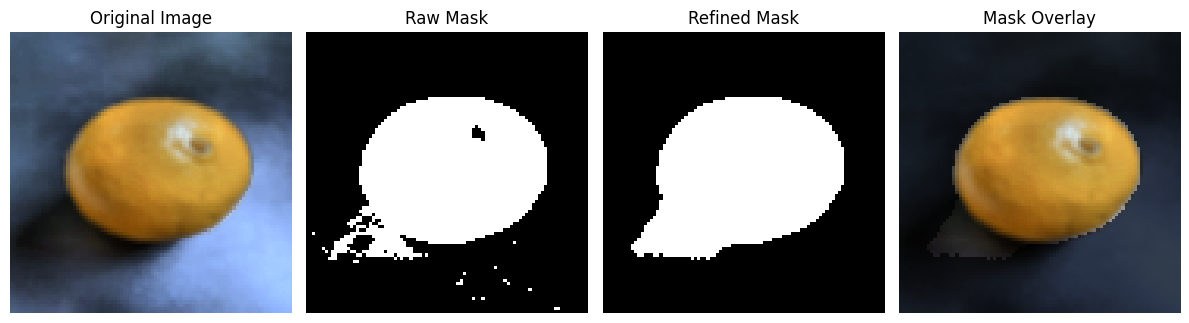

Feature vector shape: (94,)
First 10 features: [ 2.4270000e+03  2.0582338e+02  4.1779170e+00  7.1992999e-01
  9.4638330e-01  7.3943061e-01  1.1917627e-01 -1.0000000e+00
  1.3696363e-16 -2.5140991e-16]


In [41]:
# --------------------------
# PIPELINE: from image to feature vector
# --------------------------

# 1. STEP 1: Image Normalization
image_path = "/home/zilou/Liveproject/01610963_001.jpg"
img = load_and_normalize(image_path)

# 2. STEP 2: Segmentation
raw_mask = segment_fruit(img)

# 3. STEP 3: Mask Refinement
mask_refined = refine_mask(raw_mask)

# 4. STEP 4: Shape Representation
shape_feats = compute_shape_features(mask_refined)

# 5. STEP 5: Ripeness / Colour Features
colour_feats = compute_colour_features(img, mask_refined)

# 6. STEP 6: Build Feature Vector
feature_vector = build_feature_vector(shape_feats, colour_feats)

# --------------------------
# Optional: Visualization
# --------------------------
visualize_mask(img, raw_mask, mask_refined)

# --------------------------
# Inspect feature vector
# --------------------------
print("Feature vector shape:", feature_vector.shape)
print("First 10 features:", feature_vector[:10])